# Case study: Out-of-distribution generalization
## Task b1: Predicting $\tilde{I}_1$ from other measurements (Figure 5)

In [1]:
import sys
sys.path = ['../'] + sys.path

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Auxiliary functions

#### Plotting

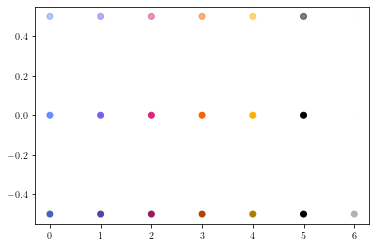

In [4]:

# Set tex formatting for plots
# Set tex formatting for plots
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

# Color palettes
ibm_color_blind = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#ffffff"]

palette = ibm_color_blind
base = to_rgb(palette)
basea = to_rgb(palette, a=0.5)
baseb = to_rgb(palette, b=0.7)
plt.scatter(np.arange(len(base)), np.zeros(len(base)), c = base)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, c = basea)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, c = baseb)

### Load dataset

In [5]:
import causalchamber.datasets as datasets
from causalchamber.ground_truth import latex_name
chamber_dataset = datasets.Dataset(name="lt_interventions_standard_v1", root="/tmp")
#chamber_dataset.available_experiments()


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or models for your work please consider citing:

@article{gamella2024chamber,
  title={The Causal Chambers: Real Physical Systems as a Testbed for AI Methodology},
  author={Gamella, Juan L. and B"uhlmann, Peter and Peters, Jonas},
  journal={arXiv preprint arXiv:TODO},
  year={2024}
}

Dataset lt_interventions_standard_v1 found in "/tmp/lt_interventions_standard_v1".


Select experiments: `uniform_reference` will be the training dataset, the others will be the ood validation datasets.

In [6]:
experiments ={    
    'uniform_reference': r"$\emptyset$",
    'uniform_red_mid': latex_name("red"),
    'uniform_green_mid': latex_name("green"),
    'uniform_blue_mid': latex_name("blue"),
    'uniform_t_vis_1_mid': latex_name("t_vis_1"),
    'uniform_t_vis_2_mid': latex_name("t_vis_2"),
    'uniform_t_vis_3_mid': latex_name("t_vis_3"),
    'uniform_t_ir_2_mid': latex_name("t_ir_2"),
    'uniform_pol_1_strong': latex_name("pol_1"),
    }

In [7]:
dataframes = dict((e,chamber_dataset.get_experiment(e).as_pandas_dataframe()) for e in experiments.keys())

Split `uniform_reference` into train and validation

In [8]:
n_validate = 1000
df_validate_train = dataframes['uniform_reference'].sample(n=n_validate)
df_train_all = dataframes['uniform_reference'].drop(df_validate_train.index).sample(100)

validation_experiments = {'uniform_reference': df_validate_train}
for experiment,df in dataframes.items():
    if experiment not in ['uniform_reference']:
        validation_experiments[experiment] = df.sample(n=n_validate)

### Fit linear models with different sets of predictors

In [9]:
import statsmodels.api as sm

def fit_and_evaluate(predictors, response='ir_1'):
    df = df_train_all
    Y = df[response]
    X = df[predictors]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    metric = {}
    for i,(name,df) in enumerate(validation_experiments.items()):        
        preds = model.predict(results.params, sm.add_constant(df[predictors]))
        mae = abs(preds - df.ir_1).sum() / len(df)
        metric[name] = mae        
    return metric

Define predictor sets

In [10]:
models = [    
    ['red'],
    ['red', 'green'],
    ['red', 'green', 'blue'],    
    ['red', 'green', 'blue', 'vis_1'],
    ['ir_2', 'ir_3', 'vis_1', 'vis_2', 'vis_3'],
    [],
]

Fit and compute MAE

In [11]:
metrics = {}
for predictors in models:
    if len(predictors) == 0:
        name="mean"
    else:
        name = ",".join([latex_name(p, enclose=False) for p in predictors])
    metrics[name] = fit_and_evaluate(predictors)

/home/juan/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:
df = pd.DataFrame.from_dict({str(i): metrics[i] for i in metrics.keys()},
                       orient='index')
df.columns = [experiments[c] for c in df.columns]
#df /= 1000
df = df.reset_index().rename(columns={'index': 'predictors'})
df

,predictors,$\emptyset$,$R$,$G$,$B$,$T^V_1$,$T^V_2$,$T^V_3$,$T^I_2$,$\theta_1$
0,R,2456.588894,2552.863977,7533.414904,4939.299164,2492.775496,2457.539840,2438.658152,2444.988245,2432.026896
1,"R,G",1625.403705,1854.153856,2030.974638,5118.991401,1614.107792,1647.467997,1719.489354,1613.261030,1647.671208
2,"R,G,B",1022.711373,1453.641816,1329.701775,1190.869265,1012.607649,1004.716736,1104.851816,1009.693085,1010.473046
3,"R,G,B,\tilde{V}_1",686.078555,955.292419,1030.921273,1277.445897,5559.365202,681.710627,706.664841,640.206055,641.015086
4,"\tilde{I}_2,\tilde{I}_3,\tilde{V}_1,\tilde{V}_...",820.326028,1259.608512,1158.229040,1432.017049,5231.876754,3552.165501,1885.704606,4833.865069,1112.171763
5,mean,3720.415120,12133.868000,7693.951280,5347.373560,3767.519880,3849.857600,3766.696560,3771.192480,3814.709160


### Plot results: spider plot

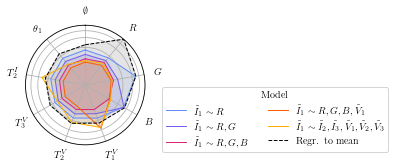

In [13]:
# Taken from https://python-graph-gallery.com/391-radar-chart-with-several-individuals/

mmax = df.values[:,1:].max()
plt.figure(figsize=(2.2,2.2))

def t(x):
    return np.power(x, 1/3)
    
# ------- PART 1: Create background
 
# number of variables
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
yticks = np.linspace(0,mmax,5)
plt.yticks(t(yticks), [])
plt.ylim(0,t(mmax))
 

# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't make a loop, because plotting more than 3 groups makes the chart unreadable
 
for i in range(len(df)):    
    values=df.loc[i].drop('predictors').values.flatten().tolist()
    values += values[:1]
    values = t(values)
    model_name = df.loc[i].predictors
    #linestyle = '-' if model_name in ["R", "R,G","R,G,B"] else '--'     
    #color = 'black' if model_name == "R,G,B" else base[i]    
    if model_name == "mean":
        label = "Regr. to mean"
        linestyle = "--"
        color = np.array([0,0,0,1])
    else:
        label = r"$\tilde{I}_1 \sim " + model_name + "$"
        linestyle = "-"
        color = base[i]
    ax.plot(angles, values, linewidth=1, linestyle=linestyle, label=label, color = color)
    ax.fill(angles, values, color=color*np.array([1,1,1,0.1]))

# Add legend
legend = plt.legend(loc='lower left', bbox_to_anchor=(1.1, -0.1), title='Model', ncol=2)
#legend._legend_box.align = "left"

# Show the graph
plt.savefig("../figures/tabular_regression.pdf", bbox_inches="tight", transparent="True")

### Alternative plots

In [14]:
maes_all_models = {}
for _,row in df.iterrows():
    maes_all_models[row.predictors] = row.values[1:]
maes_all_models

{'R': array([2456.588893582235, 2552.863976925586, 7533.414903989424,
        4939.299164007627, 2492.7754959865356, 2457.5398395438697,
        2438.658152185337, 2444.988245025674, 2432.026896196053],
       dtype=object),
 'R,G': array([1625.403705483789, 1854.1538560511106, 2030.9746383801246,
        5118.9914008318365, 1614.1077924528931, 1647.4679971404612,
        1719.4893535166098, 1613.2610303435888, 1647.6712083350462],
       dtype=object),
 'R,G,B': array([1022.7113725068914, 1453.641815805023, 1329.701774997667,
        1190.8692649082884, 1012.6076492228599, 1004.7167360242019,
        1104.8518159665648, 1009.6930853157022, 1010.4730460433985],
       dtype=object),
 'R,G,B,\\tilde{V}_1': array([686.0785550292109, 955.2924185311115, 1030.9212731784116,
        1277.4458967060737, 5559.36520202094, 681.7106273551994,
        706.6648413160858, 640.2060550691695, 641.0150862124765],
       dtype=object),
 '\\tilde{I}_2,\\tilde{I}_3,\\tilde{V}_1,\\tilde{V}_2,\\tilde{V}_3'

<Figure size 158.4x158.4 with 0 Axes>

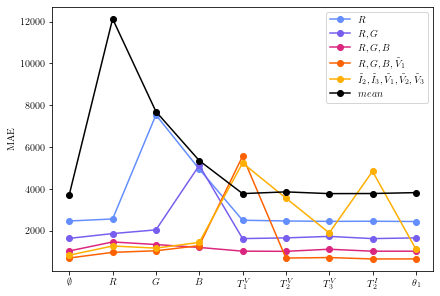

In [15]:
# Taken from https://python-graph-gallery.com/391-radar-chart-with-several-individuals/

mmax = df.values[:,1:].max()
plt.figure(figsize=(2.2,2.2))

# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

datasets = df.columns[1:]

x = np.arange(len(datasets))*1.5  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for i,(model, maes) in enumerate(maes_all_models.items()):          
    rects = ax.plot(x, maes, label="$" + model + "$", color=base[i], marker='o')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('MAE')
ax.set_xticks(x, datasets)
ax.legend(loc='upper right', ncol=1)
#ax.set_ylim(0, 250)

plt.show()

R
R,G
R,G,B
R,G,B,\tilde{V}_1
\tilde{I}_2,\tilde{I}_3,\tilde{V}_1,\tilde{V}_2,\tilde{V}_3
mean


<Figure size 158.4x158.4 with 0 Axes>

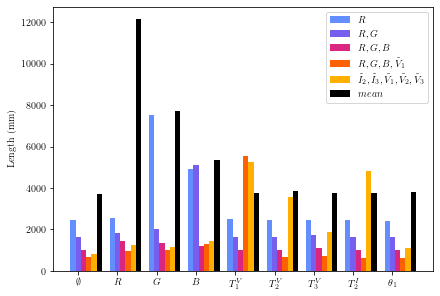

In [16]:
# Taken from https://python-graph-gallery.com/391-radar-chart-with-several-individuals/

mmax = df.values[:,1:].max()
plt.figure(figsize=(2.2,2.2))

# data from https://allisonhorst.github.io/palmerpenguins/

import matplotlib.pyplot as plt
import numpy as np

datasets = df.columns[1:]

x = np.arange(len(datasets))*1.5  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for i,(model, maes) in enumerate(maes_all_models.items()):
    print(model)
    offset = width * multiplier    
    rects = ax.bar(x + offset, maes, width, label="$" + model + "$", color=base[i])
    #ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_xticks(x + width, datasets)
ax.legend(loc='upper right', ncol=1)
#ax.set_ylim(0, 250)

plt.show()

### Additional scatter plot for the figure

/home/juan/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:981: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


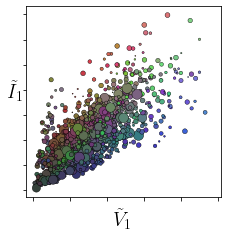

In [17]:
plt.figure(figsize=(3.5,3.5))
kwargs = {'edgecolor': 'black', 'linewidth': 0.4}
df_all = pd.concat(dataframes.values(), ignore_index=True).sample(2000)
x = df_all[['red', 'green', 'blue']].values.mean(axis=1)
c = df_all[['red', 'green', 'blue']].values / 255 + 0.2
plt.scatter(df_all.vis_1,df_all.ir_1,c=c, **kwargs,s=df_all.pol_1)
#plt.xticks([], [])
#plt.yticks([], [])
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.ylabel(latex_name('ir_1'), rotation=0, fontsize=20)
plt.xlabel(latex_name('vis_1'), rotation=0, fontsize=20)
plt.savefig("../figures/sensor_scatter.pdf", bbox_inches='tight')